# Gaussian Mixture Models

## What is a Gaussian?

Gaussian is the most famous and important of all statistical distributions, its also known as normal distribution or bell curve.
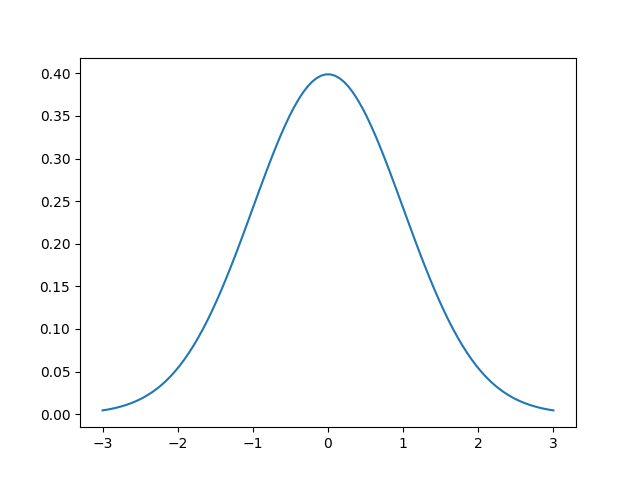
Fig: A gaussian centered at 0 with a standard deviation of 1

Function that describes the normal distribution is:
$$ \mathcal{N}(x; \mu, \sigma^2) = \displaystyle\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\displaystyle\frac{(x-\mu)^2}{2\sigma^2}}  $$
It has one input and two parameters.

The two parameters are called the mean $\mu$ and standard deviation $\sigma$. In some cases, the standard deviation is replaced with the variance $\sigma^2$, which is just the square of the standard deviation.

The mean of the Gaussian simply shifts the center of the Gaussian, i.e., the “bump” or top of the bell. In the image above, $\mu=0$, so the largest value is at $x=0$.

The standard deviation is a measure of the spread of the Gaussian. It affects the “wideness” of the bell. Using a larger standard deviation means that the data are more spread out, rather than closer to the mean.

Input -> the probability of observing an input x, given that specific normal distribution.

Gaussians can be extended in any no of dimensions _(Multivariate Gaussians)_

## What are Gaussian Mixture Models?

The idea behind Gaussian Mixture Models is to find the parameters of the Gaussians that best explain our data.

Assume that data are Gaussian and find parameters that maximize the likelihood of observing the data.
In other words, regard each point as being generated by a mixture of Gaussians and compute that probability.

$$\begin{align*} p(x) = \displaystyle\sum_{j=1}^{k} \phi_j\mathcal{N}(x; \mu_j, \Sigma_j)\\ \displaystyle\sum_{j=1}^{k} \phi_j = 1 \end{align*}$$

A particular data point x is a linear combination of the k Gaussians.

Weight each Gaussian with $\phi_j$, which represents the strength of that Gaussian.

The second equation is a constraint on the weights: they all have to sum up to 1.

Three different parameters need to be updated:
* Weights for each Gaussian $\phi_j$
* Means of the Gaussians $\mu_j$
* Covariances of each Gaussian $\Sigma_j$

## Expectation-Maximization (EM) Algorithm

Use EM Algorithm to update learn the parameters of GMM.

Two steps:
1. **Expectation**: compute the probability that each data point was generated by each of the k Gaussians.

2. **Maximization**: update weights, means, and covariances.

**Expectation step**:
$$W^{(i)}{_j} =  \displaystyle\frac{\phi_j\mathcal{N}(x^{(i)}; \mu_j, \Sigma_j)}{\displaystyle\sum_{q=1}^{k}\phi_q\mathcal{N}(x^{(i)}; \mu_q, \Sigma_q)}$$

**Maximization step**:
$$\begin{align*} \phi_j &= \displaystyle\frac{1}{N}\sum_{i=1}^N W^{(i)}_j\\ \mu_j &= \displaystyle\frac{\sum_{i=1}^N W^{(i)}_j x^{(i)}}{\sum_{i=1}^N W^{(i)}_j}\\ \Sigma_j &= \displaystyle\frac{\sum_{i=1}^N W^{(i)}_j (x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^T}{\sum_{i=1}^N W^{(i)}_j} \end{align*}$$

## Applications of GMM

* Clustering
* Density Estimation
* Create new data samples using generative modeling

## Code for GMM

### Import needed libraries

In [20]:
import numpy as np
import pandas as pd
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn # for computing mvn 
import matplotlib.pyplot as plt
import seaborn as sns

### Define functions

In [10]:
# randomly initialize gmm parameters -> means, covariances & weights (strength of each gaussian)
def initialize_gmm_parameters(v_noOfVariables, k_noOfGaussDist, cov_scale=1):
    # initialize k random nos ( range 0-1 ) as weights for each gaussian in gmm
    W_gaussWeights = np.random.random(k_noOfGaussDist)
    # since the weights must sum up to 1 (constraint) we divide each weight by total sum of weights
    W_gaussWeights /= W_gaussWeights.sum() 
    
    # randomly initialize v means for each gaussian in th range 0-100
    U_gaussMeans = np.random.randint(0, 100, (k_noOfGaussDist, v_noOfVariables))
    
    # initialize k covariance matrices each (v*v) for every gaussian, use identity matrices 
    S_covMatrices = np.array([np.eye(v_noOfVariables)] * k_noOfGaussDist ) * cov_scale # generate k matrices each v*v
    
    return [W_gaussWeights, U_gaussMeans, S_covMatrices]

In [68]:
# fit the data X to gmm and the return the optimal paramters
def gmm_fit(X, k_noOfGaussDist, tol=0.1, max_iter=100):
    """Uses Expectation Maximization (EM) algorithm"""
    # look at the data
    n_noOfSamples, v_noOfVariables = X.shape
    # initialize parameters 
    W_gaussWeights, U_gaussMeans, S_covMatrices = initialize_gmm_parameters(v_noOfVariables, k_noOfGaussDist, X.std())
    ll_history = []
    ll_old = 0 # log-likelihood
    # start training
    print('Iterations: ', end='')
    for i in range(max_iter):
        print(str(i) + '.', end='')
        
        # E-STEP ->
            # Compute the probability that each data point was generated by each of the k Gaussians.
            # In other words, compute a matrix where the rows are the data points & the cols are the Gaussians, 
                # an element at row i, column j is the probability that x{i} was generated by Gaussian j.
        
        # initialize matrix E with zeros
        E = np.zeros((k_noOfGaussDist, n_noOfSamples))
        
        # for each sample compute the probability that it belongs to each of the k Gaussians
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                # first form a gaussian with the current parameters then calculate probability for sample
                E[j, i] = W_gaussWeights[j] * mvn(U_gaussMeans[j], S_covMatrices[j], allow_singular=True).pdf(X[i])
        
        # sum of probabilities for different gaussians on a sample must be one so we divide by the sum  
        E /= E.sum(0)
        
        # M-STEP ->
            # In this step, update weights, means, & covariances.
            # 1. For weights -> sum up the probability that each point was generated by Gaussian j and
                # divide by the total number of points.
            # 2. For means -> compute the mean of all points weighted by the probability of that point 
                # being generated by Gaussian j.
            # 3. For covariances -> compute the covariance of all points weighted by the probability of that point
                # being generated by Gaussian j.
            # Do each of these for each Gaussian j.
        
        # Update weights (strength of each gaussian)
        W_gaussWeights = np.zeros(k_noOfGaussDist)
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                W_gaussWeights[j] += E[j, i]
        W_gaussWeights /= n_noOfSamples

        # Update means
        U_gaussMeans = np.zeros((k_noOfGaussDist, v_noOfVariables))
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                U_gaussMeans[j] += E[j, i] * X[i]
            U_gaussMeans[j] /= E[j, :].sum()
 
        # Update covariances
        S_covMatrices = np.zeros((k_noOfGaussDist, v_noOfVariables, v_noOfVariables))
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                ys = np.reshape(X[i] - U_gaussMeans[j], (v_noOfVariables, 1))
                S_covMatrices[j] += E[j, i] * np.dot(ys, ys.T)
            S_covMatrices[j] /= E[j, :].sum()

        # update complete log likelihoood
        # iterate till log-likelihood doesn't change upto a certain tolerance 
        ll_new = 0.0
        for i in range(n_noOfSamples):
            s = 0
            for j in range(k_noOfGaussDist):
                s += W_gaussWeights[j] * mvn(U_gaussMeans[j], S_covMatrices[j], allow_singular=True).pdf(X[i])
            ll_new += np.log(s)
#         print(f'log_likelihood: {ll_new:3.4f}; ')
        ll_history.append(ll_old)
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new        
        
    return [ll_history,W_gaussWeights.round(2), U_gaussMeans.round(2), S_covMatrices.round(2)] # return the learned optimal parameters

### Example demo

#### Generate Data

In [71]:
def generate_random_samples(k, v):
    # generate data from k gaussians each having v features(variables)
    weights, means, covariances = initialize_gmm_parameters(v, k) # randomly initialize gmm parameters
    print('\n\nActual Weights: \n %s' % weights)
    print('Actual Means: \n %s' % means)
    print('Actual Covariances: \n %s' % covariances)
    n = 100 # no of samples
    # generate n random samples from these parameters 
    xs = np.concatenate([np.random.multivariate_normal(m, s, int(w*n))
                        for w, m, s in zip(weights, means, covariances)])
    return xs



Actual Weights: 
 [0.48039194 0.24207731 0.27753075]
Actual Means: 
 [[15 85 16]
 [91 91 22]
 [10 31  3]]
Actual Covariances: 
 [[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]


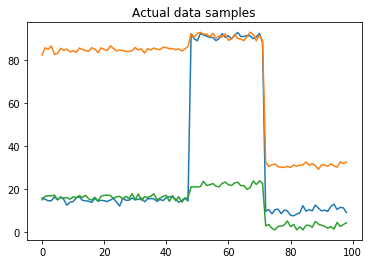

In [84]:
no_of_gaussians = 3
variables = 3
X = generate_random_samples(no_of_gaussians, variables)
plt.plot(X)
_ = plt.title('Actual data samples')

#### Train on the above data

Iterations: 0.1.2.3.

Output Weights: 
 [0.27 0.   0.73]
Output Means: 
 [[10.11 31.11  2.81]
 [12.5  30.91  4.88]
 [40.29 87.   18.05]]
Output Covariances: 
 [[[ 1.88000e+00  8.00000e-02  2.00000e-02]
  [ 8.00000e-02  7.50000e-01 -9.00000e-02]
  [ 2.00000e-02 -9.00000e-02  1.20000e+00]]

 [[ 8.00000e-02  3.00000e-02  3.00000e-02]
  [ 3.00000e-02  1.00000e-02  1.00000e-02]
  [ 3.00000e-02  1.00000e-02  1.00000e-02]]

 [[ 1.28598e+03  1.05440e+02  1.00030e+02]
  [ 1.05440e+02  9.75000e+00  8.31000e+00]
  [ 1.00030e+02  8.31000e+00  8.74000e+00]]]


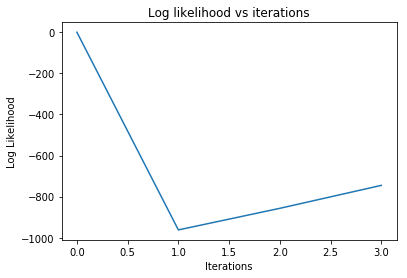

In [90]:
# train these samples in gmm to get predicted parameters 
ll, weights, means, covariances = gmm_fit(X, no_of_gaussians)
print('\n\nOutput Weights: \n %s' % weights)
print('Output Means: \n %s' % means)
print('Output Covariances: \n %s' % covariances)
# plot log likelihood versus iterations plot
plt.plot(ll)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
_=plt.title('Log likelihood vs iterations')

#### Generate new output samples (Generative modeling)

C:\Users\aszen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


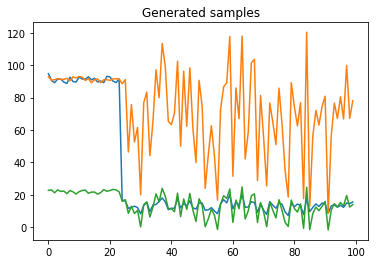

In [89]:
n = 100
output_samples = np.concatenate([np.random.multivariate_normal(m, s, int(w*n))
                        for w, m, s in zip(weights, means, covariances)])
plt.plot(output_samples)
_=plt.title('Generated samples')

## References

The following resources were used extensively for research, ideas, guidance and inspiration while making this project.

[1] - https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

[2] - http://nbviewer.jupyter.org/github/BlackArbsCEO/Mixture_Models/blob/K-Means,-E-M,-Mixture-Models/E-M,%20K-Means,%20Mixture%20Models.ipynb?flush_cache=true

[3] - https://mubaris.com/2017/10/01/kmeans-clustering-in-python/

[4] - https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

[5] - https://www.youtube.com/watch?v=W0XECm4-3LI

[6] - https://www.youtube.com/watch?v=m-jVjTchpiE

[7] - http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/